# Playground

Used for testing on the fly new features

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from PytorchModulePCA import PytorchModulePCA
from PytorchModulePCA.utils import torch_img2numpy_img
from fastai.vision import *
from fastai.layers import simple_cnn

device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
TRAIN = False

train_ds = MNIST(root='~/Documents/datasets/', download=True, transform=ToTensor())
train_dl = DataLoader(train_ds, num_workers=14, batch_size=128, shuffle=True)
test_ds = MNIST(root='~/Documents/datasets/', download=True, transform=ToTensor(), train=False)
test_dl = DataLoader(test_ds, num_workers=14, batch_size=128, shuffle=False)

data = ImageDataBunch(train_dl, test_dl) # create DataBunch

model = simple_cnn((1, 16, 32, 10)).to(device) # a random model

In [13]:
learn = Learner(data, model, path='./', loss_func=CrossEntropyFlat())
learn.metrics=[accuracy]
# train and store
if TRAIN:
    learn.fit(10, lr=1e-03)
    learn.save('mnist-simple', return_path=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.825643,0.760996,0.765900,00:08
1,0.538773,0.501235,0.846000,00:08
2,0.443258,0.402794,0.881700,00:08
3,0.370200,0.342876,0.898900,00:07
4,0.340098,0.314016,0.908100,00:08
5,0.315592,0.312869,0.901900,00:08
6,0.282520,0.274477,0.918700,00:07
7,0.271231,0.250394,0.926800,00:07
8,0.265317,0.244827,0.929700,00:07
9,0.250189,0.239646,0.926300,00:07


In [28]:
learn.load('./mnist-simple')

model = learn.model
last_conv_layer = model[2][0] # get the last conv layer

module_pca = PytorchModulePCA(model.eval(), last_conv_layer.eval(), learn.data.valid_dl)
module_pca(k=8, n_batches=2) # run only on 4 batches
# module_pca.plot() # plot
# module_pca.annotate()
# plt.savefig('./images/example')
# df = module_pca.state.to_df() # get the points as pandas df
# print(df)

In [60]:
imgs, img, info = module_pca.query(0)
dist, _ = info

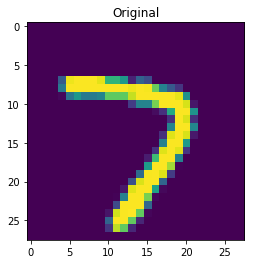

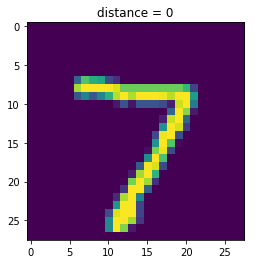

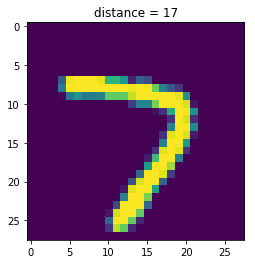

In [62]:
fig = plt.figure()
plt.title('Original')
plt.imshow(img)
plt.show()
for d, img in zip(dist[0], imgs):
    fig = plt.figure()
    plt.title(f"distance = {d}")
    plt.imshow(img)
    plt.show()